In [1]:
import cppchess as chess
from mcts.c import run_mcts
import tensorflow as tf
from game import Game
from config import Config
import numpy as np

2024-03-11 09:18:08.291633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Testing bot vs random move

In [2]:
#model_name = "r6c64Ad1e-4L2b64"
model_name = "test"
model_path = f"models/{model_name}/saved_model"
model = tf.saved_model.load(model_path)
trt_func = model.signatures["serving_default"]

2024-02-27 10:59:15.432708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5823 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


In [3]:
NUM_GAMES = 1
BOT_COLOR = chess.WHITE
ALTERNATE_COLORS = True
config = Config()
results = {
    model_name: 0,
    "Opponent": 0,
}
for _ in range(NUM_GAMES):
    board = chess.Board()
    game = Game(board)
    while not game.terminal_with_outcome():
        if game.to_play() == BOT_COLOR:
            move, _ = run_mcts(
                game=game,
                config=config,
                network=trt_func,
                root=None,
                reuse_tree=False,
                num_simulations=config.num_mcts_sims,
                num_sampling_moves=0,
                add_noise=False,
                pb_c_factor=1.5,
            )
        else:
            move = np.random.default_rng().choice(game.legal_moves())
        game.make_move(move)
    print(game.outcome_str)
    if game.terminal_value(BOT_COLOR) == 1:
        results[model_name] += 1
    elif game.terminal_value(BOT_COLOR) == -1:
        results["Opponent"] += 1
    else:
        results[model_name] += 0.5
        results["Opponent"] += 0.5
    if ALTERNATE_COLORS:
        BOT_COLOR = not BOT_COLOR
print(results)

2024-02-27 10:59:22.443594: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2024-02-27 10:59:22.443661: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2024-02-27 10:59:27.897508: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1329] [TF-TRT] Sparse compute capability: enabled.


White wins: outcome=Checkmate
{'test': 1, 'Opponent': 0}


## Testing Bot vs MCTS with random values

In [2]:
model_name = "test"
model_path = f"models/{model_name}/saved_model"
model = tf.saved_model.load(model_path)
trt_func = model.signatures["serving_default"]

""" def fake_network(_):
    tf.random.set_seed(0)
    return {
        "value_head": tf.random.uniform([1, 1], -1, 1),
        "policy_head": tf.random.uniform([1, 4672], -1, 1),
    } """

def fake_network(_):
    gen = np.random.default_rng()
    return {
        "value_head": tf.convert_to_tensor(gen.uniform(-1, 1, [1, 1]), dtype=tf.float32),
        "policy_head": tf.convert_to_tensor(gen.uniform(-1, 1, [1, 4672]), dtype=tf.float32),
    }

2024-03-11 09:18:25.461838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5635 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


In [3]:
NUM_GAMES = 10
BOT_COLOR = chess.WHITE
ALTERNATE_COLORS = True
config = Config()
results = {
    model_name: 0,
    "Opponent": 0,
}
for _ in range(NUM_GAMES):
    board = chess.Board()
    game = Game(board)
    while not game.terminal_with_outcome():
        if game.to_play() == BOT_COLOR:
            move, _ = run_mcts(
                game=game,
                config=config,
                network=trt_func,
                root=None,
                reuse_tree=False,
                num_simulations=config.num_mcts_sims,
                num_sampling_moves=config.num_mcts_sampling_moves,
                add_noise=config.add_dirichlet_noise,
                pb_c_factor=config.pb_c_factor,
            )
        else:
            move, _ = run_mcts(
                game=game,
                config=config,
                network=fake_network,
                root=None,
                reuse_tree=False,
                num_simulations=config.num_mcts_sims,
                num_sampling_moves=config.num_mcts_sampling_moves,
                add_noise=config.add_dirichlet_noise,
                pb_c_factor=config.pb_c_factor,
            )
        game.make_move(move)
    print(game.outcome_str)
    if game.terminal_value(BOT_COLOR) == 1:
        results[model_name] += 1
    elif game.terminal_value(BOT_COLOR) == -1:
        results["Opponent"] += 1
    else:
        results[model_name] += 0.5
        results["Opponent"] += 0.5
    if ALTERNATE_COLORS:
        BOT_COLOR = not BOT_COLOR
print(results)

2024-03-11 09:18:31.447883: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2024-03-11 09:18:31.447956: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2024-03-11 09:18:37.137871: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1329] [TF-TRT] Sparse compute capability: enabled.


Draw: outcome=Threefold repetition
Draw: outcome=Threefold repetition
Draw: outcome=Threefold repetition
Draw: outcome=Threefold repetition
Draw: outcome=Threefold repetition
Draw: outcome=Threefold repetition
Draw: outcome=Threefold repetition
Draw: outcome=Threefold repetition
Draw: outcome=Threefold repetition
Draw: outcome=Threefold repetition
{'test': 5.0, 'Opponent': 5.0}


In [4]:
results

{'test': 3.5, 'Opponent': 5.5}

## Testing Bot vs Other bot

In [1]:
import cppchess as chess
from mcts.c import run_mcts
from game import Game
from config import Config

model1_name = "r4c48Ad1e-5L2b64"
#model2_name = "r4c48Ad1e-4L2b64"
model2_name = "test"

2024-03-01 12:08:11.411458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from multiprocessing import Manager, Process

def play_game(name, color, num_games, alternate_colors, history, results, barrier):
    import tensorflow as tf
    gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

    model_path = f"models/{name}/saved_model"
    model = tf.saved_model.load(model_path)
    trt_func = model.signatures["serving_default"]
    
    for i in range(num_games):
        config = Config()
        board = chess.Board()
        game = Game(board)
        while not game.terminal_with_outcome():
            if game.to_play() == color:
                move, _ = run_mcts(
                    game=game,
                    config=config,
                    network=trt_func,
                    root=None,
                    reuse_tree=False,
                    num_simulations= 600, #config.num_mcts_sims,
                    num_sampling_moves=config.num_mcts_sampling_moves,
                    add_noise=config.add_dirichlet_noise,
                    pb_c_factor=config.pb_c_factor,
                )
                history[i].append(move)
            barrier.wait()
            game.make_move(history[i][-1])

        if game.terminal_value(color) == 1:
            results[name] += 1
        elif game.terminal_value(color) != -1:
            results[name] += 0.5
        if alternate_colors:
            color = not color

if __name__ == "__main__":
    NUM_GAMES = 20
    ALTERNATE_COLORS = True
    with Manager() as manager:
        barrier = manager.Barrier(2)
        history = manager.list()
        for _ in range(NUM_GAMES):
            history.append(manager.list())
        results = manager.dict({
            model1_name: 0,
            model2_name: 0,
        })
        p1 = Process(target=play_game, args=(model1_name, chess.WHITE, NUM_GAMES, ALTERNATE_COLORS, history, results, barrier))
        p2 = Process(target=play_game, args=(model2_name, chess.BLACK, NUM_GAMES, ALTERNATE_COLORS, history, results, barrier))
        p1.start()
        p2.start()
        p1.join()
        p2.join()
        print(results)


2024-03-01 08:49:54.075402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5959 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-01 08:49:54.075407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5959 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-01 08:49:56.915209: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2024-03-01 08:49:56.923441: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2024-03-01 08:50:02.602346: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1329] [TF-TRT] Sparse compute capability: enabled.
2024-03-01 08:50:32.789663: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT

{'r4c48Ad1e-5L2b64': 12.5, 'test': 7.5}


## Playing vs bot

In [16]:
import chess
from game import Game
from mcts import run_mcts
from config import Config
import tensorflow as tf

player = chess.WHITE
#model_name = "test"
#model_path = f"models/{model_name}/saved_model"
model_path = "train/checkpoints/trt/05-03-2024_07:53:45/saved_model"
model = tf.saved_model.load(model_path)
trt_func = model.signatures["serving_default"]

config = Config()
game = Game(chess.Board())

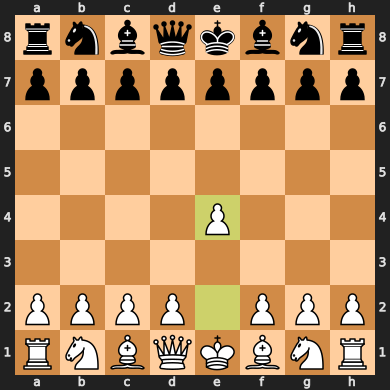

In [17]:
if game.to_play() == player:
    move = input("Enter move: ")
    game.make_move(move)
else:
    move, _ = run_mcts(
        game=game,
        config=config,
        network=trt_func,
        root=None,
        reuse_tree=False,
        num_simulations=3200,
        num_sampling_moves=0,
        add_noise=False,
        pb_c_factor=1.0,
        verbose_move=True,
    )
    game.make_move(move)
game.board

In [12]:
import tensorflow as tf
model_name = "test"
#model_name = "r4c48Ad1e-5L2b64"
model_path = f"models/{model_name}/saved_model"
model = tf.saved_model.load(model_path)
trt_func = model.signatures["serving_default"]

In [2]:
import cppchess as chess
from mcts.c import run_mcts
from game import Game
from config import Config
from tf_funcs import fake_network
config = Config()

#game = Game(chess.Board(fen="5rk1/pp3p1p/5Pp1/6Q1/q7/8/P4PPP/5R1K w Qq - 0 1"))
game = Game(chess.Board())
game.make_move("e2e4")
game.make_move("e7e5")
game.make_move("f1c4")
game.make_move("b8c6")
game.make_move("d1h5")
game.make_move("g8f6")
#game.make_move("a2a3")
""" move, root = run_mcts(
        game=game,
        config=config,
        network=trt_func,
        root=None,
        reuse_tree=False,
        num_simulations=600,
        num_sampling_moves=0,
        add_noise=True,
        pb_c_factor=1.5,
    ) """

' move, root = run_mcts(\n        game=game,\n        config=config,\n        network=trt_func,\n        root=None,\n        reuse_tree=False,\n        num_simulations=600,\n        num_sampling_moves=0,\n        add_noise=True,\n        pb_c_factor=1.5,\n    ) '

In [1]:
import tensorflow as tf
#import cppchess as chess
#from mcts.c import run_mcts
import chess
from mcts import run_mcts
from game import Game
from config import Config
from tf_funcs import fake_network
    
""" def fake_network(_):
    return {
        "value_head": g.uniform([1, 1], -1, 1),
        "policy_head": g.uniform([1, 4672], -5, 5),
    } """


#model_name = "seed-model"
#model_name = "r4c48Ad1e-5L2b64"
#model_path = f"models/{model_name}/saved_model"
model_path = "train/checkpoints/trt/05-03-2024_07:53:45/saved_model"
model = tf.saved_model.load(model_path)
trt_func = model.signatures["serving_default"]

game = Game(chess.Board())
game.make_move("e2e4")
game.make_move("e7e5")
game.make_move("f1c4")


move, root = run_mcts(
    game=game,
    config=Config(),
    network=fake_network,
    root=None,
    reuse_tree=False,
    num_simulations=1600,
    num_sampling_moves=0,
    add_noise=True,
    pb_c_factor=1.0,
    verbose_move=True
)

2024-03-05 09:08:21.248284: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 09:08:22.848676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5820 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


Evaluation: 0.208564
Best variation: f8d6 -> e1f1 -> g8e7 -> c4d5 -> b8a6 -> f1e1 -> a6b8 -> g2g3 -> c7c6 -> b1a3 -> h8g8
Move          Visits  NN Output                    Policy             Prior          Avg. value     UCB            Q+U           
----------------------------------------------------------------------------------------------------------------------------------
f8d6  (1177)  N: 305  (v: 0.900177, p:  4.622564)  (p_norm:  18.49%)  (P: 0.156484)  (Q: 0.509893)  (U: 0.537064)  (Q+U: 1.046957)
a7a6  (4161)  N: 252  (v: 0.537318, p:  4.008122)  (p_norm:  10.00%)  (P: 0.075649)  (Q: 0.522037)  (U: 0.537924)  (Q+U: 1.059962)
d7d5  (2417)  N: 145  (v: 0.740586, p:  2.258004)  (p_norm:   1.74%)  (P: 0.043468)  (Q: 0.520485)  (U: 0.536304)  (Q+U: 1.056789)
f8c5  (1185)  N: 126  (v: 0.932584, p:  1.552120)  (p_norm:   0.86%)  (P: 0.006436)  (Q: 0.534995)  (U: 0.537688)  (Q+U: 1.072683)
b7b6  (3577)  N: 104  (v: 0.438815, p:  4.626584)  (p_norm:  18.56%)  (P: 0.146719)  (Q: 0.46

In [9]:
s = 0
w = 0
for m, child in root.children.items():
    print(f"{m}: {child.W} / {child.N} = {child.Q}")
    s += child.N
    w += child.W

print()
for m, child in root.pruned_children.items():
    print(f"{m}: {child.W} / {child.N} = {child.Q}")
    s += child.N
    w += child.W
print()
print(move)
print(s)
print(w)

f6d5: 3.697408437728882 / 212 = 0.01744060583834378

h8g8: -0.04923748970031738 / 1 = -0.04923748970031738
f8e7: -0.7136986255645752 / 1 = -0.7136986255645752
f8c5: -0.37766075134277344 / 1 = -0.37766075134277344
f8a3: -0.7359840869903564 / 1 = -0.7359840869903564
d8e7: -0.05942273139953613 / 1 = -0.05942273139953613
f6e4: -0.24944853782653809 / 1 = -0.24944853782653809
c6e7: -0.5268270969390869 / 1 = -0.5268270969390869
c6b4: -0.5099880695343018 / 1 = -0.5099880695343018
g7g6: -0.36073851585388184 / 1 = -0.36073851585388184
f6h5: -0.17832040786743164 / 3 = -0.05944013595581055
c6d4: -0.6625442504882812 / 3 = -0.22084808349609375
a7a6: -0.49986720085144043 / 3 = -0.16662240028381348
g7g5: -1.6855719089508057 / 3 = -0.5618573029836019
f8d6: -1.5751314163208008 / 4 = -0.3937828540802002
c6a5: -0.24512004852294922 / 4 = -0.061280012130737305
f6g8: 0.12641167640686035 / 5 = 0.02528233528137207
d7d6: -0.18048572540283203 / 6 = -0.03008095423380534
f6g4: -1.8303782939910889 / 7 = -0.26148261